### Importing Required Modules and Libraries

In [1]:
#! pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from scipy.sparse import hstack

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score


### Loading the cleanined data

In [3]:
sentiment_df_cleaned = pd.read_csv("../data/Interim/sentiment_df_cleaned.csv").drop(["Unnamed: 0"], axis=1)
sentiment_df_cleaned.head()

,statement,status,statement_cleaned,tokens,tokens_joined,tokens_joined_lemma,character_count,word_count,sentence_count,avg_character_per_word,avg_character_per_sentence,avg_word_per_sentence
0,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,take anymore take anymore take anymore take an...,"['take', 'anymore', 'take', 'anymore', 'take',...",take anymor take anymor take anymor take anymo...,take anymore take anymore take anymore take an...,32759,6300,1260,5.199841,25.999206,5.000000
1,Please help me understand what I went through ...,Personality disorder,please help understand went going lengthy ahea...,"['please', 'help', 'understand', 'went', 'goin...",pleas help understand went go lengthi ahead ti...,please help understand went going lengthy ahea...,27588,5419,374,5.090976,73.764706,14.489305
2,I have only 1 person I can somewhat open to bu...,Suicidal,person somewhat open done certain extent try r...,"['person', 'somewhat', 'open', 'done', 'certai...",person somewhat open done certain extent tri r...,person somewhat open done certain extent try r...,27390,5248,237,5.219131,115.569620,22.143460
3,DEPRESSION HAS A PURPOSE: HOW TO USE IT RIGHT ...,Bipolar,depression purpose use right text discusses pe...,"['depression', 'purpose', 'use', 'right', 'tex...",depress purpos use right text discuss person e...,depression purpose use right text discus perso...,26163,4804,430,5.446087,60.844186,11.172093
4,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,aa please want stop,"['aa', 'please', 'want', 'stop']",aa pleas want stop,aa please want stop,25302,8,1,3162.750000,25302.000000,8.000000


In [4]:
sentiment_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   statement                   53043 non-null  object 
 1   status                      53043 non-null  object 
 2   statement_cleaned           52852 non-null  object 
 3   tokens                      53043 non-null  object 
 4   tokens_joined               52852 non-null  object 
 5   tokens_joined_lemma         52852 non-null  object 
 6   character_count             53043 non-null  int64  
 7   word_count                  53043 non-null  int64  
 8   sentence_count              53043 non-null  int64  
 9   avg_character_per_word      53043 non-null  float64
 10  avg_character_per_sentence  53043 non-null  float64
 11  avg_word_per_sentence       53043 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 4.9+ MB


In [5]:
sentiment_df_cleaned[sentiment_df_cleaned.isna().any(axis=1)]

,statement,status,statement_cleaned,tokens,tokens_joined,tokens_joined_lemma,character_count,word_count,sentence_count,avg_character_per_word,avg_character_per_sentence,avg_word_per_sentence
21689,[Cross-post] World Bipolar Day AMA on r/IAmA! ...,Bipolar,NaN,[],NaN,NaN,434,44,4,9.863636,108.5,11.0
38781,'«ð š «ð ©ð ²ð «..â £ ® © ®ð ¡ð ð ²ð «ð ..ðŸ' ...,Normal,NaN,[],NaN,NaN,86,25,1,3.440000,86.0,25.0
41652,37.795120 -122.44502037.794440 -122.43321037.7...,Suicidal,NaN,[],NaN,NaN,63,4,1,15.750000,63.0,4.0
42986,”ð ®ð ®ð £ð ˜¬ð ©ð ˜¯ð ˜ºð . ˜¢ð ±ð ®ð ®ð ®ð ®...,Normal,NaN,[],NaN,NaN,54,18,3,3.000000,18.0,6.0
44259,https://t.co/6MPqRunPeX https://t.co/6MPqRunPeX,Suicidal,NaN,[],NaN,NaN,47,2,1,23.500000,47.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
53031,so?,Normal,NaN,[],NaN,NaN,3,1,1,3.000000,3.0,1.0
53034,no.,Normal,NaN,[],NaN,NaN,3,1,1,3.000000,3.0,1.0
53035,so?,Normal,NaN,[],NaN,NaN,3,1,1,3.000000,3.0,1.0
53039,so?,Normal,NaN,[],NaN,NaN,3,1,1,3.000000,3.0,1.0


In [6]:
sentiment_df_cleaned = sentiment_df_cleaned.dropna()
sentiment_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52852 entries, 0 to 53042
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   statement                   52852 non-null  object 
 1   status                      52852 non-null  object 
 2   statement_cleaned           52852 non-null  object 
 3   tokens                      52852 non-null  object 
 4   tokens_joined               52852 non-null  object 
 5   tokens_joined_lemma         52852 non-null  object 
 6   character_count             52852 non-null  int64  
 7   word_count                  52852 non-null  int64  
 8   sentence_count              52852 non-null  int64  
 9   avg_character_per_word      52852 non-null  float64
 10  avg_character_per_sentence  52852 non-null  float64
 11  avg_word_per_sentence       52852 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 5.2+ MB


## Data preprocessing

In [7]:
sentiment_df_cleaned.describe()

,character_count,word_count,sentence_count,avg_character_per_word,avg_character_per_sentence,avg_word_per_sentence
count,52852.000000,52852.000000,52852.000000,52852.000000,52852.000000,52852.000000
mean,576.836411,112.787558,6.262904,5.289046,130.160425,25.871952
std,845.538809,163.599694,10.675387,13.843532,319.001260,62.059856
min,2.000000,1.000000,1.000000,2.000000,2.000000,0.500000
25%,79.000000,15.000000,1.000000,4.800000,47.000000,9.000000
50%,314.000000,62.000000,3.000000,5.073529,74.000000,14.375000
75%,750.000000,148.000000,8.000000,5.411436,109.400000,21.005814
max,32759.000000,6300.000000,1260.000000,3162.750000,25302.000000,4239.000000


In [8]:
sentiment_df_cleaned[["character_count","word_count","sentence_count","avg_character_per_word","avg_character_per_sentence","avg_word_per_sentence"]].skew()

character_count                 6.656465
word_count                      6.237093
sentence_count                 35.568669
avg_character_per_word        224.692139
avg_character_per_sentence     21.719503
avg_word_per_sentence          15.333774
dtype: float64

All the features have skewness values greater than 1, indicating substantial right skewness. Features like sentence_count and avg_character_per_word are extremely skewed, suggesting that there are some instances with very high values that are pulling the mean up.

To address the skewness in the features, I applied Log Transformation which is effective for reducing skewness, especially for features with positive values. 

In [9]:
sentiment_df_cleaned['character_count_log'] = np.log(sentiment_df_cleaned['character_count'])
sentiment_df_cleaned['word_count_log'] = np.log(sentiment_df_cleaned['word_count'])
sentiment_df_cleaned['sentence_count_log'] = np.log(sentiment_df_cleaned['sentence_count'])
sentiment_df_cleaned['avg_character_per_word_log'] = np.log(sentiment_df_cleaned['avg_character_per_word'])
sentiment_df_cleaned['avg_character_per_sentence_log'] = np.log(sentiment_df_cleaned['avg_character_per_sentence'])
sentiment_df_cleaned['avg_word_per_sentence_log'] = np.log(sentiment_df_cleaned['avg_word_per_sentence'])

sentiment_df_cleaned = sentiment_df_cleaned.drop(columns=["character_count", "word_count", "sentence_count", 
                                    "avg_character_per_word", "avg_character_per_sentence", 
                                    "avg_word_per_sentence"])


In [10]:
sentiment_df_cleaned[["character_count_log","word_count_log","sentence_count_log","avg_character_per_word_log","avg_character_per_sentence_log","avg_word_per_sentence_log"]].skew()

character_count_log              -0.301029
word_count_log                   -0.336550
sentence_count_log                0.414256
avg_character_per_word_log        4.559928
avg_character_per_sentence_log    0.669487
avg_word_per_sentence_log         0.594981
dtype: float64

### Separating features and target variables

In [58]:
X = sentiment_df_cleaned[['tokens_joined',
       'character_count_log', 'word_count_log', 'sentence_count_log',
       'avg_character_per_word_log', 'avg_character_per_sentence_log',
       'avg_word_per_sentence_log']]
lable_enc = LabelEncoder()
y = lable_enc.fit_transform(sentiment_df_cleaned["status"])

In [12]:
X.shape

(52852, 7)

In [13]:
y.shape

(52852,)

## Spliting the data into training and testing sets

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123, stratify = y)

In [15]:
print("Training set class distribution:", Counter(y_train))
print("Test set class distribution:", Counter(y_test))

Training set class distribution: Counter({3: 12933, 2: 12322, 6: 8519, 0: 3110, 1: 2301, 5: 2135, 4: 961})
Test set class distribution: Counter({3: 3233, 2: 3081, 6: 2130, 0: 778, 1: 575, 5: 534, 4: 240})


## TF-IDF vectorization

TF-IDF is a powerful technique for text analysis that helps to identify the significance of words in documents relative to a larger corpus, making it invaluable for various natural language processing tasks.
TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (corpus). It is commonly used in text mining and information retrieval, particularly for tasks like document classification, clustering, and searching.

**Term Frequency (TF)**: Measures how frequently a term occurs in a document.

$$ TF(t, d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d}$$
 
A higher TF indicates that the term is more important in that specific document.

**Inverse Document Frequency (IDF)**: Measures how important a term is across the entire corpus.

$$IDF(𝑡) = ln(\frac{\text{Total number of documents}}{\text{Number of documents containing term 𝑡}})$$

**A higher IDF value indicates that the term is rare across documents, making it more significant when it does appear.**

The TF-IDF score combines these two metrics:

$$\text{TF-IDF}(t,d)=TF(t,d)×IDF(t)$$
This means that common words across many documents (like "the", "is", "and") will have low TF-IDF scores, while rare words that appear frequently in a specific document will have high TF-IDF scores.

**First check how many unique words the data contains**

In [16]:
# Parse each string to a list and flatten
#flattened_list = set(token for sublist in sentiment_df_cleaned["tokens"] for token in ast.literal_eval(sublist))

#print(flattened_list)

In [17]:
#print(len(flattened_list))

In [18]:
#Apply TF-IDF Vectorization to the text data
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df = 0.8, max_features = 50000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['tokens_joined'])  # Fit and transform on training set
X_test_tfidf = tfidf_vectorizer.transform(X_test['tokens_joined']) 

## Scaling numeric features

In [19]:
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train[[
       'character_count_log', 'word_count_log', 'sentence_count_log',
       'avg_character_per_word_log', 'avg_character_per_sentence_log',
       'avg_word_per_sentence_log']])
X_test_numeric_scaled = scaler.transform(X_test[[
       'character_count_log', 'word_count_log', 'sentence_count_log',
       'avg_character_per_word_log', 'avg_character_per_sentence_log',
       'avg_word_per_sentence_log']])


## Combining text and numeric data

In [20]:
X_train_combined = hstack((X_train_tfidf, X_train_numeric_scaled))
X_test_combined = hstack((X_test_tfidf, X_test_numeric_scaled))

In [21]:
X_train_combined.shape

(42281, 50006)

In [22]:
X_test_combined.shape

(10571, 50006)

In [51]:
X_test_combined

<10571x50006 sparse matrix of type '<class 'numpy.float64'>'
	with 680479 stored elements in COOrdinate format>

## Reshapling the data to fix the category imbalance

In [23]:
ros = RandomOverSampler(random_state=123)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

In [24]:
X_train_resampled.shape

(90531, 50006)

## Bernoulli Naive Bayes

In [25]:
# Define the parameter grid
param_grid_bnb = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
}

# Initialize the model
bnb = BernoulliNB()

# Initialize GridSearchCV
grid_search_bnb = GridSearchCV(estimator=bnb, param_grid=param_grid_bnb, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search_bnb.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and best score
print(f'Best Parameters: {grid_search_bnb.best_params_}')
print(f'Best Score: {grid_search_bnb.best_score_}')

# Train the model with the best parameters
best_bnb = grid_search_bnb.best_estimator_
best_bnb.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_best_bnb = best_bnb.predict(X_test_combined)
print(f'accuracy_score: {accuracy_score(y_test, y_pred_best_bnb)}')
# Evaluate the model
print("Tuned Bernoulli Naive Bayes")
print(classification_report(y_test, y_pred_best_bnb))

Best Parameters: {'alpha': 0.0001}
Best Score: 0.7820305569569446
accuracy_score: 0.6375934159492952
Tuned Bernoulli Naive Bayes
              precision    recall  f1-score   support

           0       0.74      0.50      0.60       778
           1       0.79      0.42      0.55       575
           2       0.56      0.60      0.58      3081
           3       0.73      0.92      0.81      3233
           4       0.84      0.23      0.36       240
           5       0.52      0.25      0.33       534
           6       0.54      0.52      0.53      2130

    accuracy                           0.64     10571
   macro avg       0.67      0.49      0.54     10571
weighted avg       0.64      0.64      0.62     10571



In [26]:
# List of alpha values to test

alpha_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
accuracy_scores_bnb_indi = []

# Loop through each alpha value, fit the model, and calculate accuracy
for alpha in alpha_values:
    # Initialize the model with current alpha
    bnb_indi = BernoulliNB(alpha=alpha, force_alpha=True)
    
    # Fit the model on the training data
    bnb_indi.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the test set
    y_pred_bnb_indi = bnb_indi.predict(X_test_combined)
    
    # Calculate the accuracy score
    accuracy_bnb_indi = accuracy_score(y_test, y_pred_bnb_indi)
    accuracy_scores_bnb_indi.append(accuracy_bnb_indi)

In [27]:
accuracy_scores_bnb_indi

[0.6375934159492952,
 0.638633998675622,
 0.6383502033866237,
 0.6369312269416327,
 0.6310661243023366,
 0.6236874467883833,
 0.5983350676378772,
 0.5795099801343297]

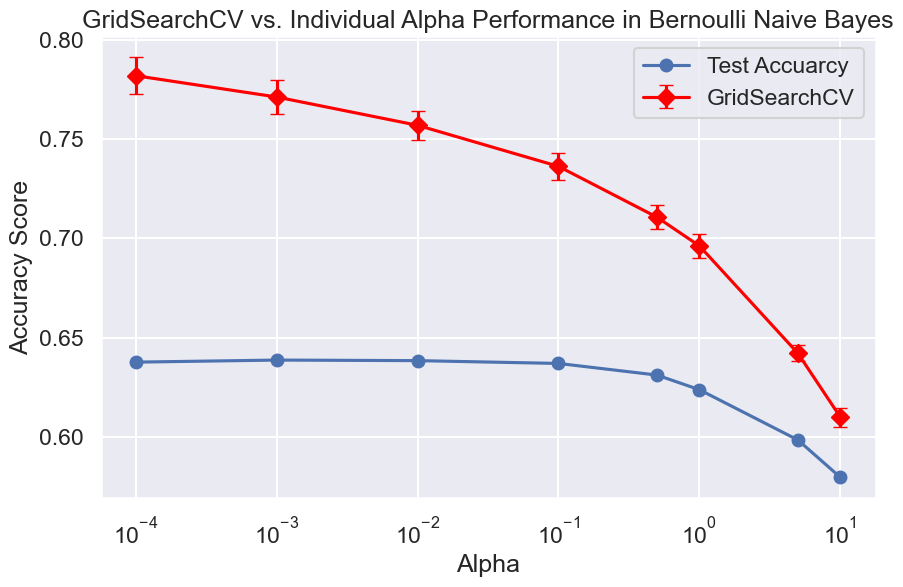

In [28]:
mean_test_scores_bnb = grid_search_bnb.cv_results_['mean_test_score']
std_test_scores_bnb = grid_search_bnb.cv_results_['std_test_score']
# Plot the accuracy scores for each alpha
sns.set_theme(context = "talk")
plt.figure(figsize=(10, 6))

plt.plot(alpha_values, accuracy_scores_bnb_indi, marker='o', linestyle='-', color='b', label= "Test Accuarcy")
plt.errorbar(param_grid_bnb['alpha'], mean_test_scores_bnb, 
             yerr=std_test_scores_bnb, 
             fmt='D', linestyle='-', 
             label="GridSearchCV", color="red", 
             capsize=5)

plt.xscale('log')  # Use a logarithmic scale for the alpha axis
plt.xlabel('Alpha')
plt.ylabel('Accuracy Score')
plt.title('GridSearchCV vs. Individual Alpha Performance in Bernoulli Naive Bayes')
plt.legend()

plt.show()


## Confusion Matrix

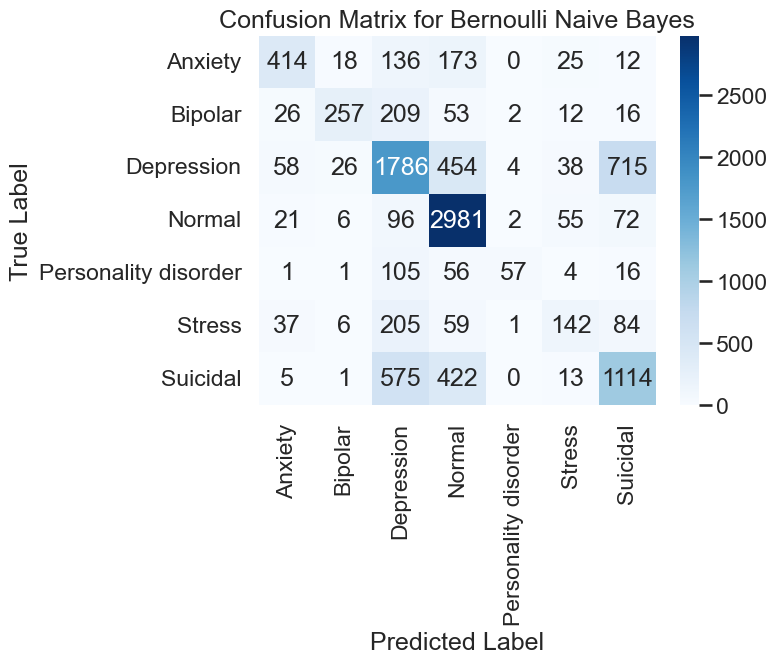

In [29]:
# Confusion Matrix
bnb_test_best = BernoulliNB(alpha=0.001, force_alpha=True)
    
    # Fit the model on the training data
bnb_test_best.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the test set
y_pred_bnb_test_best = bnb_test_best.predict(X_test_combined)
cm_bnb = confusion_matrix(y_test, y_pred_bnb_test_best)
labels = lable_enc.classes_
# Create a heatmap for the confusion matrix
sns.heatmap(cm_bnb, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Adding labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Bernoulli Naive Bayes')
plt.show()

In [30]:
print(classification_report(y_test, y_pred_bnb_test_best))
print(classification_report(y_test, y_pred_best_bnb))

              precision    recall  f1-score   support

           0       0.74      0.53      0.62       778
           1       0.82      0.45      0.58       575
           2       0.57      0.58      0.58      3081
           3       0.71      0.92      0.80      3233
           4       0.86      0.24      0.37       240
           5       0.49      0.27      0.35       534
           6       0.55      0.52      0.54      2130

    accuracy                           0.64     10571
   macro avg       0.68      0.50      0.55     10571
weighted avg       0.64      0.64      0.62     10571

              precision    recall  f1-score   support

           0       0.74      0.50      0.60       778
           1       0.79      0.42      0.55       575
           2       0.56      0.60      0.58      3081
           3       0.73      0.92      0.81      3233
           4       0.84      0.23      0.36       240
           5       0.52      0.25      0.33       534
           6       0.54 

In [76]:
def get_top_features(feature_log_probs, class_index, tfidf_vectorizer, numeric_feature_names =[
       'character_count_log', 'word_count_log', 'sentence_count_log',
       'avg_character_per_word_log', 'avg_character_per_sentence_log',
       'avg_word_per_sentence_log'], top_n=20):
    # Get top N indices from the log probabilities
    top_n_indices = np.argsort(feature_log_probs[class_index])[-top_n:][::-1]
    
    # Separate the indices into TF-IDF features and numeric features
    tfidf_count = tfidf_vectorizer.get_feature_names_out().shape[0]
    
    # Initialize lists for words and scores
    top_n_words = []
    top_n_scores = []
    
    for i in top_n_indices:
        if i < tfidf_count:
            # It's a TF-IDF feature
            top_n_words.append(tfidf_vectorizer.get_feature_names_out()[i])
            top_n_scores.append(feature_log_probs[class_index][i])
        else:
            # It's a numeric feature
            numeric_index = i - tfidf_count
            top_n_words.append(numeric_feature_names[numeric_index])
            top_n_scores.append(feature_log_probs[class_index][i])
    
    return top_n_words, top_n_scores

In [77]:

# Get top features for Depression and Suicidal classes
top_20_depression_words, top_20_depression_scores = get_top_features(
    bnb_test_best.feature_log_prob_, 
    2, 
    tfidf_vectorizer, 
    numeric_feature_names
)
top_20_suicidal_words, top_20_suicidal_scores = get_top_features(
    bnb_test_best.feature_log_prob_, 
    6, 
    tfidf_vectorizer, 
    numeric_feature_names
)

# Print the results
print(f"Top words for Depression: {top_20_depression_words}, Scores: {top_20_depression_scores}")
print(f"Top words for Suicidal: {top_20_suicidal_words}, Scores: {top_20_suicidal_scores}")

Top words for Depression: ['word_count_log', 'character_count_log', 'avg_word_per_sentence_log', 'avg_character_per_sentence_log', 'sentence_count_log', 'feel', 'like', 'want', 'get', 'depress', 'know', 'go', 'life', 'time', 'even', 'avg_character_per_word_log', 'thing', 'feel like', 'make', 'think'], Scores: [-0.2424070620777048, -0.24596051527360174, -0.3939336550030852, -0.40988221725205953, -0.541551395550961, -0.5794706252773949, -0.6324725374881055, -0.806417084645366, -0.8361231041400181, -0.8928303316198161, -0.9030790434081784, -0.9342740496530304, -0.9605966010455056, -1.0267933829161215, -1.0845615400337199, -1.1366737638698243, -1.199061972599809, -1.2080791639268469, -1.2111895855350117, -1.2130084760406596]
Top words for Suicidal: ['word_count_log', 'character_count_log', 'sentence_count_log', 'avg_word_per_sentence_log', 'want', 'avg_character_per_sentence_log', 'feel', 'like', 'go', 'life', 'know', 'get', 'think', 'even', 'time', 'would', 'live', 'one', 'die', 'avg_char

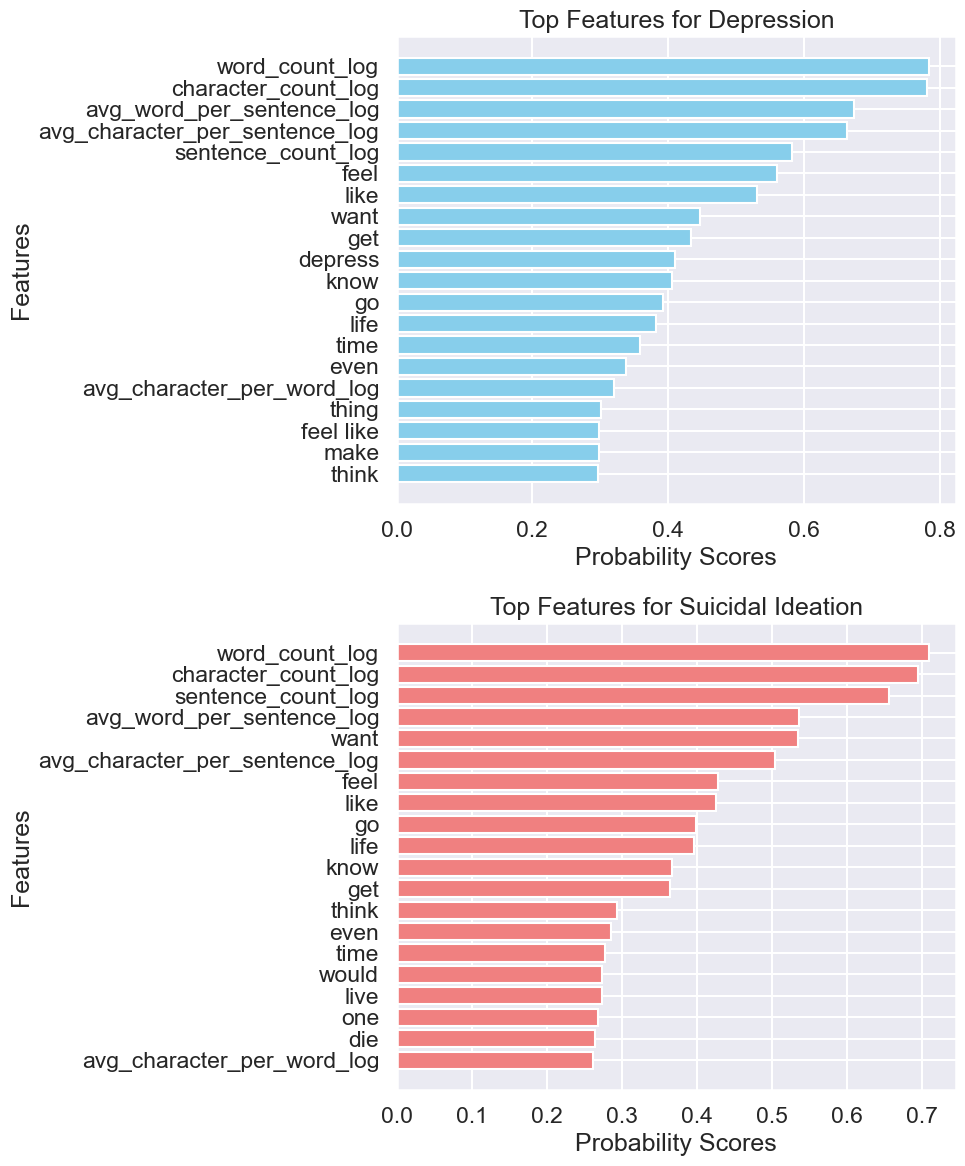

In [79]:
# Set up the figure and axis
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot for Depression
axs[0].barh(top_20_depression_words, np.exp(top_20_depression_scores), color='skyblue')
axs[0].set_title('Top Features for Depression')
axs[0].set_xlabel('Probability Scores')
axs[0].set_ylabel('Features')
axs[0].invert_yaxis()  # Invert y-axis to have the highest score at the top

# Plot for Suicidal
axs[1].barh(top_20_suicidal_words, np.exp(top_20_suicidal_scores), color='lightcoral')
axs[1].set_title('Top Features for Suicidal Ideation')
axs[1].set_xlabel('Probability Scores')
axs[1].set_ylabel('Features')
axs[1].invert_yaxis()  # Invert y-axis to have the highest score at the top

# Show the plots
plt.tight_layout()
plt.show()

In [68]:
feature_log_probs

array([[-16.3752929 ,  -6.63426545, -16.3752929 , ...,  -0.38151397,
         -0.51986143,  -0.58736923],
       [ -6.75942075,  -6.75942075, -16.3752929 , ...,  -0.27995413,
         -0.5370433 ,  -0.62305696],
       [ -7.85789973,  -6.6948864 ,  -9.46653812, ...,  -1.13667376,
         -0.40988222,  -0.39393366],
       ...,
       [ -6.03351816, -16.3752929 , -16.3752929 , ...,  -0.26906732,
         -0.48786894,  -0.54554607],
       [ -8.08099329,  -6.82840886, -16.3752929 , ...,  -0.49863194,
         -0.41748326,  -0.47014285],
       [ -8.77389056,  -7.16485253,  -8.36859205, ...,  -1.3407236 ,
         -0.68567498,  -0.62334535]])

## Logistic Regression classifier

In [31]:
# Define the parameter grid
param_grid_log_reg = {
    'C': [0.5, 1.0, 5.0, 10.0,100.0]
}

# Initialize the model
log_reg = LogisticRegression(random_state=123, solver='liblinear', penalty='l1')

# Initialize GridSearchCV
grid_search_log_reg = GridSearchCV(estimator=log_reg, param_grid=param_grid_log_reg, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search_log_reg.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and best score
print(f'Best Parameters: {grid_search_log_reg.best_params_}')
print(f'Best Score: {grid_search_log_reg.best_score_}')

# Train the model with the best parameters
best_log_reg = grid_search_log_reg.best_estimator_
best_log_reg.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_best_log_reg = best_log_reg.predict(X_test_combined)

# Evaluate the model
print("Tuned Logistic Regression")
print(classification_report(y_test, y_pred_best_log_reg))

Best Parameters: {'C': 10.0}
Best Score: 0.9074793370100711
Tuned Logistic Regression
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       778
           1       0.77      0.77      0.77       575
           2       0.68      0.67      0.68      3081
           3       0.90      0.91      0.90      3233
           4       0.56      0.69      0.62       240
           5       0.54      0.51      0.52       534
           6       0.62      0.62      0.62      2130

    accuracy                           0.74     10571
   macro avg       0.70      0.71      0.70     10571
weighted avg       0.74      0.74      0.74     10571



In [32]:
# List of alpha values to test

C_values = [0.5, 1.0, 5.0, 10.0,100.0]
accuracy_scores_log_reg_indi = []

# Loop through each alpha value, fit the model, and calculate accuracy
for C in C_values:
    # Initialize the model with current alpha
    log_reg_indi = LogisticRegression(random_state=123, solver='liblinear', penalty='l1', C=C)
    
    # Fit the model on the training data
    log_reg_indi.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the test set
    y_pred_log_reg_indi = log_reg_indi.predict(X_test_combined)
    
    # Calculate the accuracy score
    accuracy_log_reg_indi = accuracy_score(y_test, y_pred_log_reg_indi)
    accuracy_scores_log_reg_indi.append(accuracy_log_reg_indi)

In [33]:
accuracy_scores_log_reg_indi

[0.7386245388326553,
 0.7489357676662567,
 0.7458140194872765,
 0.7390975309809857,
 0.7214076246334311]

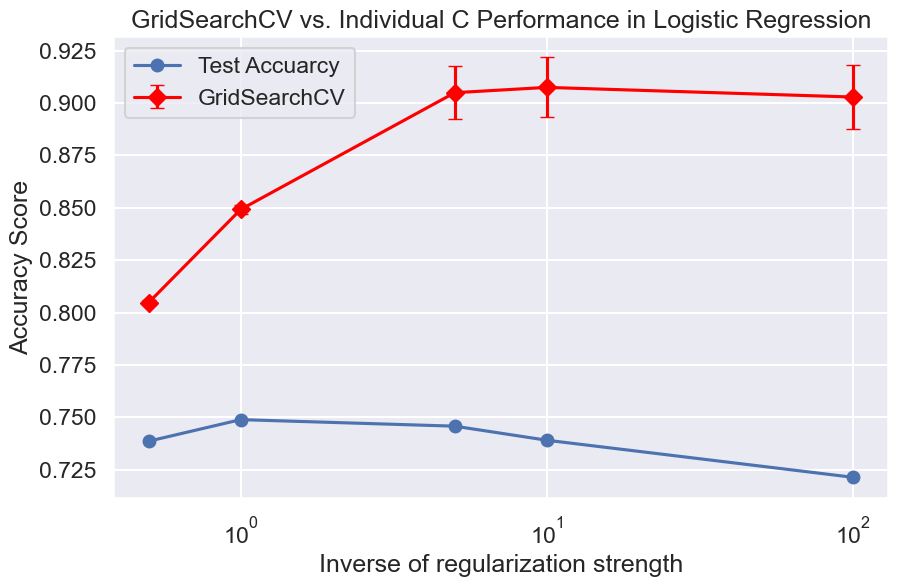

In [34]:
mean_test_scores_log_reg = grid_search_log_reg.cv_results_['mean_test_score']
std_test_scores_log_reg = grid_search_log_reg.cv_results_['std_test_score']
# Plot the accuracy scores for each C

plt.figure(figsize=(10, 6))

plt.plot(C_values, accuracy_scores_log_reg_indi, marker='o', linestyle='-', color='b', label= "Test Accuarcy")
plt.errorbar(param_grid_log_reg['C'], mean_test_scores_log_reg, 
             yerr=std_test_scores_log_reg, 
             fmt='D', linestyle='-', 
             label="GridSearchCV", color="red", 
             capsize=5)

plt.xscale('log')  # Use a logarithmic scale for the alpha axis
plt.xlabel('Inverse of regularization strength')
plt.ylabel('Accuracy Score')
plt.title('GridSearchCV vs. Individual C Performance in Logistic Regression')
plt.legend()

plt.show()

## Confusion Matrix

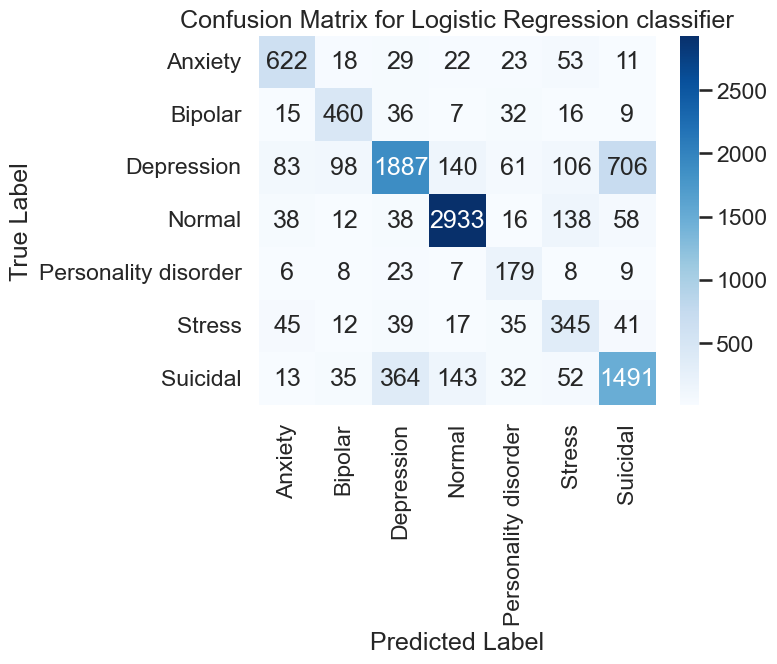

In [35]:
log_reg_test_best = LogisticRegression(random_state=123, solver='liblinear', penalty='l1', C=1.0)
    # Fit the model on the training data
log_reg_test_best.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the test set
y_pred_log_reg_test_best = log_reg_test_best.predict(X_test_combined)
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg_test_best)
labels = lable_enc.classes_
# Create a heatmap for the confusion matrix
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Adding labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression classifier')
plt.show()

In [81]:
def get_top_log_reg_features(coefs, class_index, tfidf_vectorizer, numeric_feature_names=[
       'character_count_log', 'word_count_log', 'sentence_count_log',
       'avg_character_per_word_log', 'avg_character_per_sentence_log',
       'avg_word_per_sentence_log'], top_n=20):
    # Combine TF-IDF and numeric feature names
    feature_names = tfidf_vectorizer.get_feature_names_out().tolist() + numeric_feature_names
    
    # Get coefficients for the specified class
    class_coefs = coefs[class_index]
    
    # Sort coefficients by absolute value to get the most impactful features
    top_n_indices = np.argsort(np.abs(class_coefs))[-top_n:][::-1]  # Top N absolute values in descending order
    
    # Initialize lists for words and scores
    top_n_words = [feature_names[i] for i in top_n_indices]
    top_n_scores = [class_coefs[i] for i in top_n_indices]
    
    return top_n_words, top_n_scores

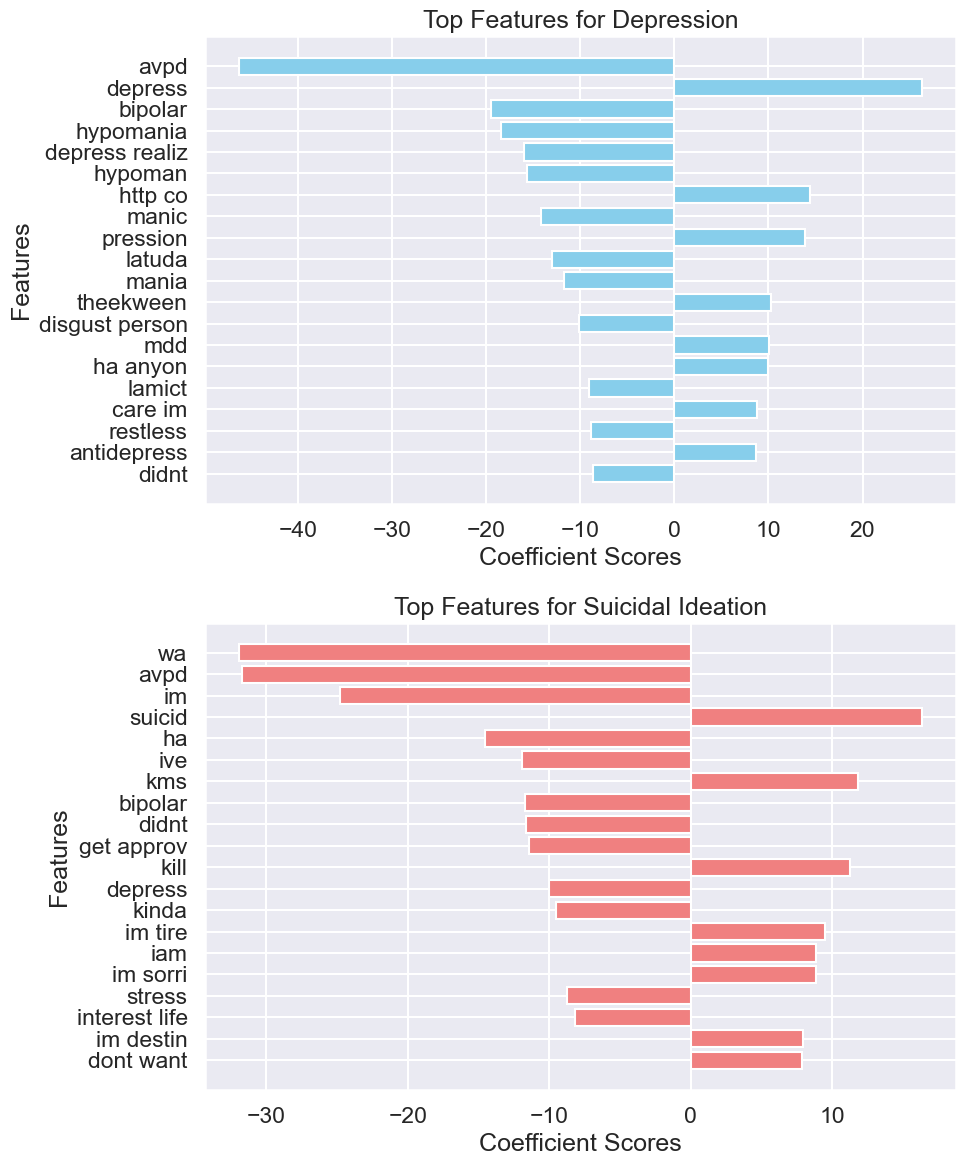

In [82]:
log_reg_top_20_depression_words, log_reg_top_20_depression_scores = get_top_log_reg_features(
    log_reg_test_best.coef_, 
    2, 
    tfidf_vectorizer, 
    numeric_feature_names
)
log_reg_top_20_suicidal_words, log_reg_top_20_suicidal_scores = get_top_log_reg_features(
    log_reg_test_best.coef_, 
    6, 
    tfidf_vectorizer, 
    numeric_feature_names
)

# Set up the figure and axis
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot for Depression
axs[0].barh(log_reg_top_20_depression_words, log_reg_top_20_depression_scores, color='skyblue')
axs[0].set_title('Top Features for Depression')
axs[0].set_xlabel('Coefficient Scores')
axs[0].set_ylabel('Features')
axs[0].invert_yaxis()  # Invert y-axis to have the highest score at the top

# Plot for Suicidal
axs[1].barh(log_reg_top_20_suicidal_words, log_reg_top_20_suicidal_scores, color='lightcoral')
axs[1].set_title('Top Features for Suicidal Ideation')
axs[1].set_xlabel('Coefficient Scores')
axs[1].set_ylabel('Features')
axs[1].invert_yaxis()  # Invert y-axis to have the highest score at the top

# Show the plots
plt.tight_layout()
plt.show()

## Decision Tree Classifier

It took too long for me to run GridSearchCV

In [37]:
min_samples_split_values = [2,3,4,5,6,7,8]
accuracy_scores_dec_tree_indi = []

# Loop through each alpha value, fit the model, and calculate accuracy
for min_samples_split in min_samples_split_values:
    # Initialize the model with current alpha
    dec_tree_indi = DecisionTreeClassifier(random_state=123, min_samples_split=min_samples_split)
    
    # Fit the model on the training data
    dec_tree_indi.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the test set
    y_pred_dec_tree_indi = dec_tree_indi.predict(X_test_combined)
    
    # Calculate the accuracy score
    accuracy_dec_tree_indi = accuracy_score(y_test, y_pred_dec_tree_indi)
    print(f'accuracy score for {min_samples_split} is {accuracy_dec_tree_indi}')
    accuracy_scores_dec_tree_indi.append(accuracy_dec_tree_indi)


accuracy score for 2 is 0.6679595118721029
accuracy score for 3 is 0.6689054961687636
accuracy score for 4 is 0.6660675432787816
accuracy score for 5 is 0.6690946930280958
accuracy score for 6 is 0.6660675432787816
accuracy score for 7 is 0.6672027244347744
accuracy score for 8 is 0.6621890076624728


This suggest that the accuracy of the model does not improve with minimum number of samples increase.

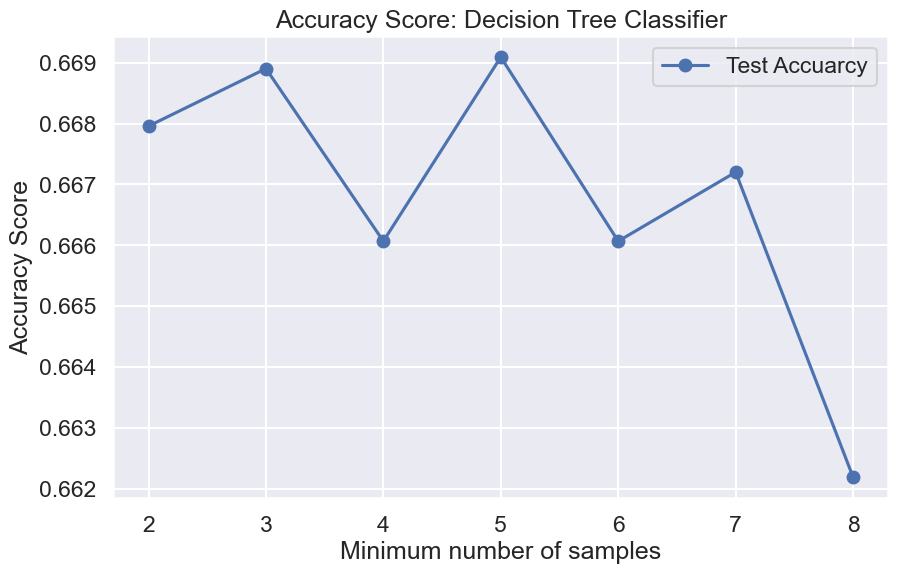

In [38]:
plt.figure(figsize=(10, 6))

plt.plot(min_samples_split_values, accuracy_scores_dec_tree_indi, marker='o', linestyle='-', color='b', label= "Test Accuarcy")

plt.xlabel('Minimum number of samples')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score: Decision Tree Classifier')
plt.legend()

plt.show()

In [39]:
max_depth_values = [None, 5, 10, 20, 30, 40, 50]

accuracy_scores_dec_tree_indi2 = []

# Loop through each alpha value, fit the model, and calculate accuracy
for max_depth in max_depth_values:
    # Initialize the model with current alpha
    dec_tree_indi2 = DecisionTreeClassifier(random_state=123, min_samples_split=5, max_depth=max_depth)
    
    # Fit the model on the training data
    dec_tree_indi2.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the test set
    y_pred_dec_tree_indi2 = dec_tree_indi2.predict(X_test_combined)
    
    # Calculate the accuracy score
    accuracy_dec_tree_indi2 = accuracy_score(y_test, y_pred_dec_tree_indi2)
    print(f'accuracy score for {max_depth} is {accuracy_dec_tree_indi2}')
    accuracy_scores_dec_tree_indi2.append(accuracy_dec_tree_indi2)

accuracy score for None is 0.6690946930280958
accuracy score for 5 is 0.5299404029893103
accuracy score for 10 is 0.6003216346608646
accuracy score for 20 is 0.662378204521805
accuracy score for 30 is 0.6726894333554063
accuracy score for 40 is 0.6711758584807492
accuracy score for 50 is 0.6698514804654243


In [40]:
accuracy_scores_dec_tree_indi2

[0.6690946930280958,
 0.5299404029893103,
 0.6003216346608646,
 0.662378204521805,
 0.6726894333554063,
 0.6711758584807492,
 0.6698514804654243]

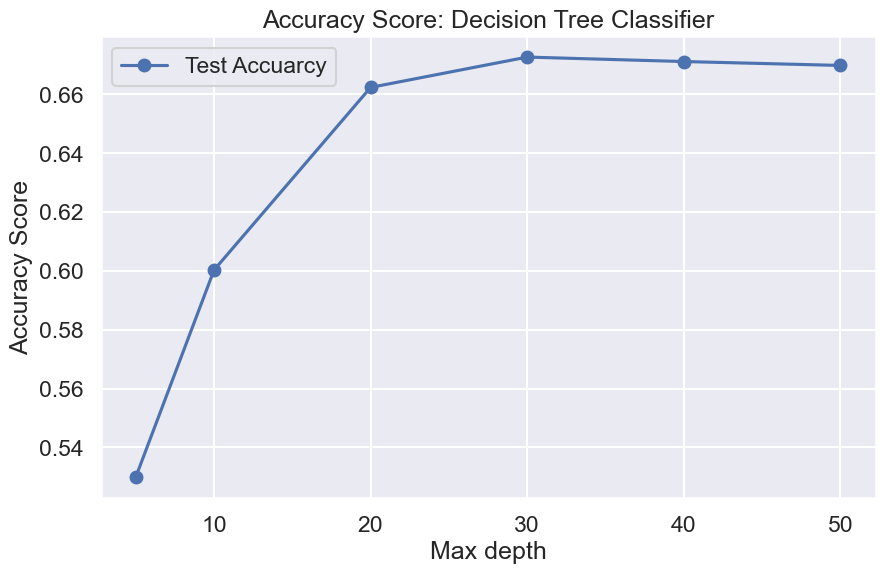

In [41]:
plt.figure(figsize=(10, 6))

plt.plot([None, 5, 10, 20, 30, 40, 50], [0.6690946930280958,
 0.5299404029893103,
 0.6003216346608646,
 0.662378204521805,
 0.6726894333554063,
 0.6711758584807492,
 0.6698514804654243], marker='o', linestyle='-', color='b', label= "Test Accuarcy")

plt.xlabel('Max depth')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score: Decision Tree Classifier')
plt.legend()

plt.show()

In [42]:
dec_tree = DecisionTreeClassifier(random_state=123, min_samples_split=5, max_depth=30)
dec_tree.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_dec_tree = dec_tree.predict(X_test_combined)

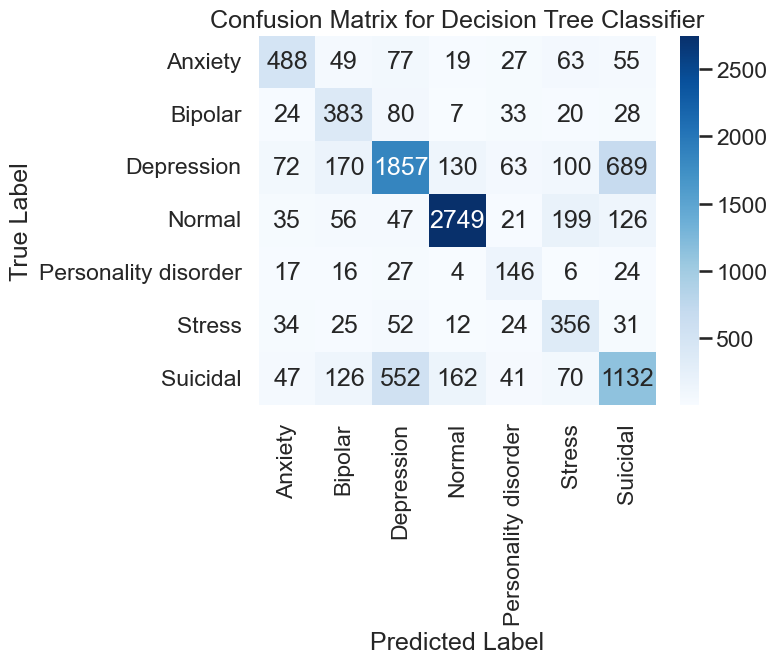

In [43]:
cm_dec_tree = confusion_matrix(y_test, y_pred_dec_tree)
labels = lable_enc.classes_
# Create a heatmap for the confusion matrix
sns.heatmap(cm_dec_tree, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Adding labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()

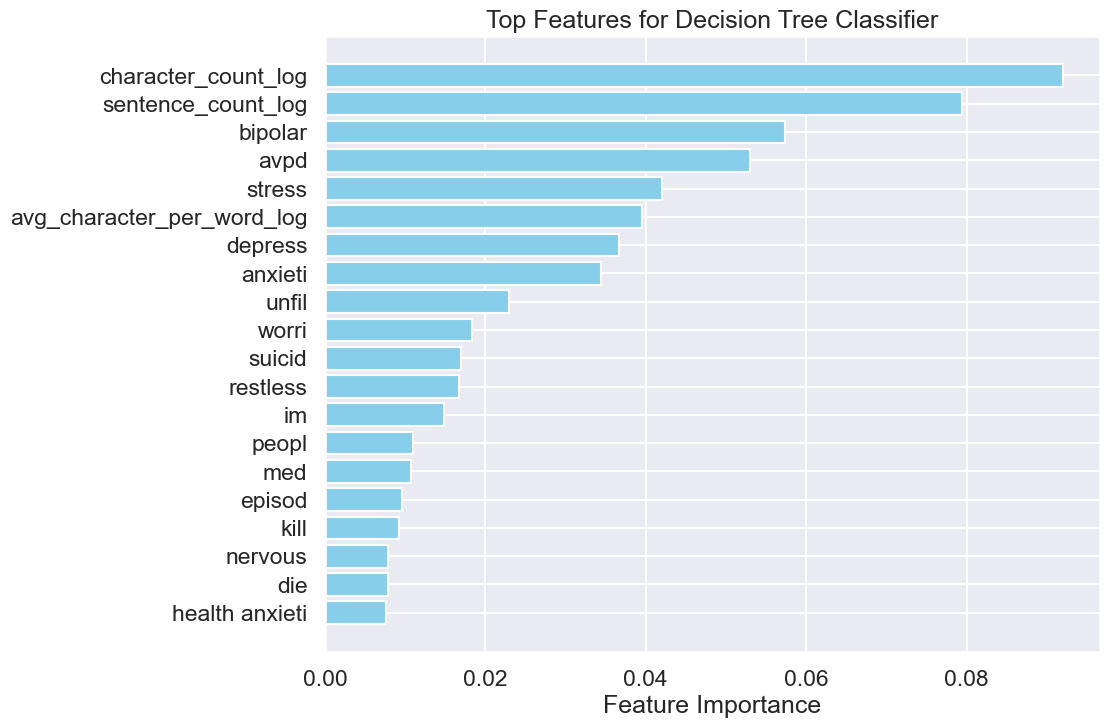

In [83]:
# Get feature importances
feature_importances = dec_tree.feature_importances_

# Combine the TF-IDF and numeric feature names (assuming you have a vectorizer and numeric features)
all_feature_names = list(tfidf_vectorizer.get_feature_names_out()) + numeric_feature_names

# Get the indices of the top features by importance
top_n = 20  # Or any number of top features you want to display
top_n_indices = np.argsort(feature_importances)[-top_n:][::-1]

# Extract the top feature names and their importances
top_n_feature_names = [all_feature_names[i] for i in top_n_indices]
top_n_feature_importances = feature_importances[top_n_indices]

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_n_feature_names, top_n_feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top Features for Decision Tree Classifier')
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.show()